In [1]:
#import the following packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import shutil
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [2]:
len(os.listdir("leafimages"))
train_path="leafimages/train"#train data path
val_path="leafimages/val"#validation or test data path

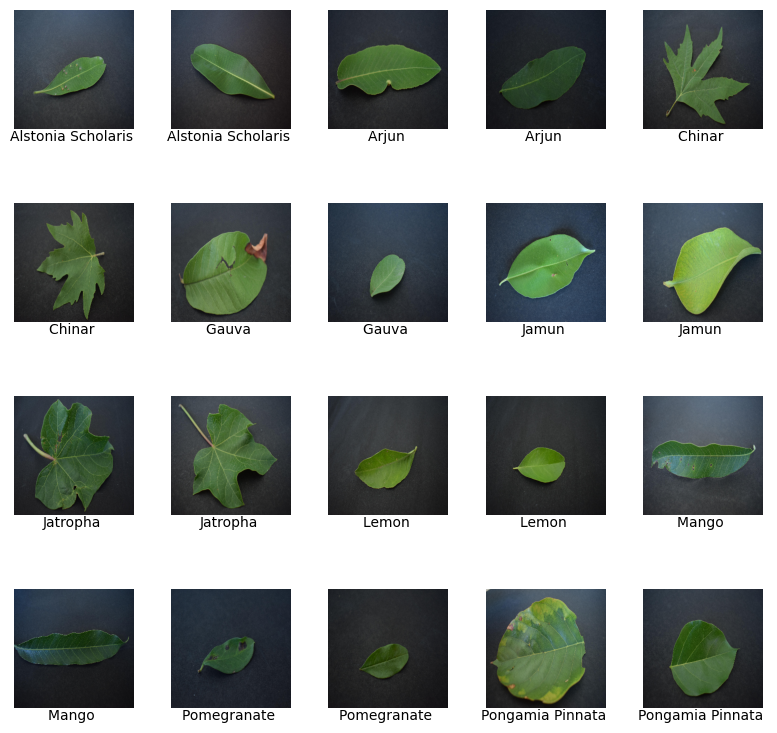

In [3]:
#this basically takes one leaf image from every file in the dataset and prints the name of the leaf with the image. it gets the name from the folder name.
image_paths=[]
names=[]
root="leafimages/train/"
for folder in os.listdir(root):
    fi=os.listdir(root+folder)[0]
    image_paths.append(root+"/"+folder+"/"+fi)
    c=0
    w=""
    for a in folder[::-1]:
       if a==" ":
           c=1
       if c==1:
            w+=a
    names.append(w[::-1])

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
axes = axes.flatten()
for i, image_path in enumerate(image_paths):
    img=load_img(image_path, target_size=(256,256))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].text(0.5, -0.1, names[i], size=10, ha="center", transform=axes[i].transAxes)


plt.tight_layout()

# Show the plot
plt.show()

In [6]:
len(os.listdir(train_path))

20

In [7]:
#pre-processing steps. we initally make objects for the imagedatagenerator which is a preprocessing technique.
train_datagen=ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
#now we use those created preprocessing objects to preprocess the data(images)

train=train_datagen.flow_from_directory(directory=train_path,target_size=(256,256),batch_size=32)
val=val_datagen.flow_from_directory(directory=val_path,target_size=(256,256),batch_size=32)

Found 3397 images belonging to 20 classes.
Found 839 images belonging to 20 classes.


In [9]:
#this next() function returns the image and the label to it in a array
t_img, label=train.next()

In [10]:
t_img.shape

(32, 256, 256, 3)

In [11]:
def plotimg(imgarr,label):
    for im, l in zip(imgarr,label):
        plt.figure(figsize=(5,5))
        plt.imshow(im/255)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


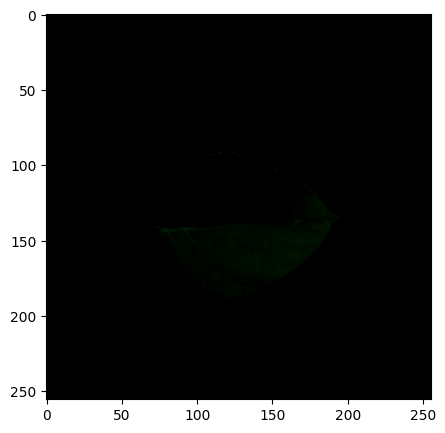

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


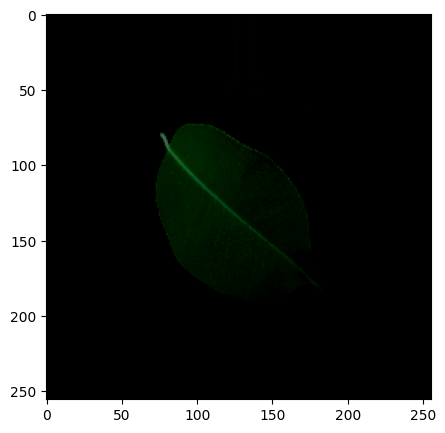

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


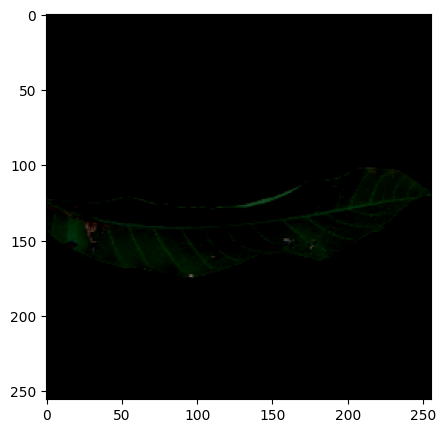

In [12]:
# we are now plotting the image after preprocessing. 
count=3 #change this to print the number of preprocessed images
plotimg(t_img[:count],label[:count])

In [13]:
#now we have our data ready to be used.
from keras.layers import Dense,Flatten
from keras.models import Model
import keras

In [14]:
#now we make the model. here we have used VGG19 model.
base_model=VGG19(input_shape=(256,256,3),include_top=False)


In [15]:
#we will actually do the transferlearning rather than training the model again. with this we get better accuracy quickly
for layer in base_model.layers:
    layer.trainable=False

In [16]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [17]:
X=Flatten()(base_model.output)
X=Dense(units=20,activation="softmax")(X)

In [18]:
model=Model(base_model.input,X)

In [19]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [20]:
model.compile(optimizer="adam",loss=keras.losses.categorical_crossentropy,metrics=["accuracy"])

In [21]:
#early stopping is used to make checkpoints and to evaluate the model for every epoch. now for each epoch we get the accuracy and validation_loss. this will also help us to save the trained model. 
#by which we can use the model again without training
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1)
mc=ModelCheckpoint(filepath="base_model.h5",monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1,save_best_only=True)
cb=[es,mc]

In [22]:
#this will train the data and return the values
his=model.fit_generator(train,epochs=3,steps_per_epoch=16,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)

C:\Users\Anudeep Bura\AppData\Local\Temp\ipykernel_12888\2428451817.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his=model.fit_generator(train,epochs=3,steps_per_epoch=16,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)


Epoch 1/3


KeyboardInterrupt: 

In [27]:

h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

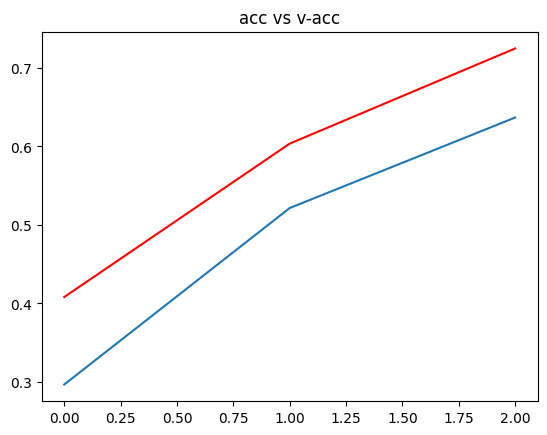

In [28]:
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"],c="red")
plt.title("acc vs v-acc")
plt.show()

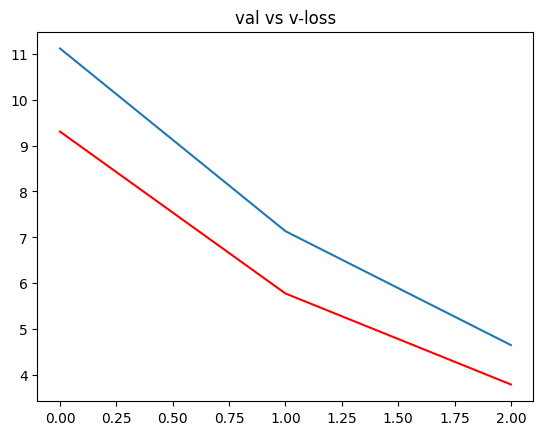

In [29]:
plt.plot(h["loss"])
plt.plot(h["val_loss"],c="red")
plt.title("val vs v-loss")
plt.show()

In [53]:
from keras.models import load_model
model=load_model("base_model.h5")

In [30]:
#this will use the generated model and find its accuracy values
acc=model.evaluate_generator(val)[1]
print("accuracy:"+acc)

C:\Users\Anudeep Bura\AppData\Local\Temp\ipykernel_9208\2430980556.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(val)[1]


KeyboardInterrupt: 

In [40]:
#this function is used to preproces the input data and make it suitable to be fitted in the prediction function 
ref=dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))
def predi(path):
    img=load_img(path, target_size=(256,256))
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    i=img_to_array(img)
    img=np.expand_dims(i,axis=0)
    pred=np.argmax(model.predict(img))
    print(ref[pred])
    plt.title("class: "+ref[pred])
    plt.show()



1/1 [==============================] - 0s 174ms/step
9
Jamun (P5)_healthy


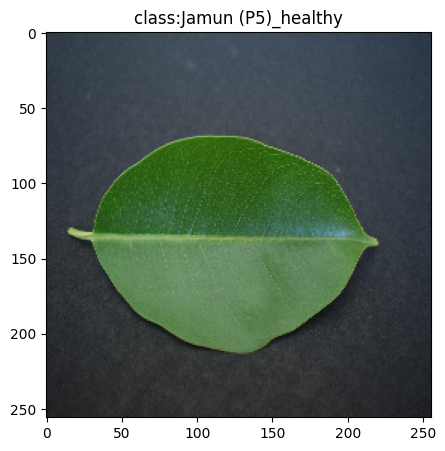

In [39]:
path="D:/scripts/ranvi/plants/leafimages/val/Jamun (P5)_healthy/0005_0036.JPG"

predi(path)

{0: 'Alstonia Scholaris (P2)_diseased',
 1: 'Alstonia Scholaris (P2)_healthy',
 2: 'Arjun (P1)_diseased',
 3: 'Arjun (P1)_healthy',
 4: 'Chinar (P11)_diseased',
 5: 'Chinar (P11)_healthy',
 6: 'Gauva (P3)_diseased',
 7: 'Gauva (P3)_healthy',
 8: 'Jamun (P5)_diseased',
 9: 'Jamun (P5)_healthy',
 10: 'Jatropha (P6)_diseased',
 11: 'Jatropha (P6)_healthy',
 12: 'Lemon (P10)_diseased',
 13: 'Lemon (P10)_healthy',
 14: 'Mango (P0)_diseased',
 15: 'Mango (P0)_healthy',
 16: 'Pomegranate (P9)_diseased',
 17: 'Pomegranate (P9)_healthy',
 18: 'Pongamia Pinnata (P7)_diseased',
 19: 'Pongamia Pinnata (P7)_healthy'}